In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import pickle

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
import kagglehub


# Download dataset
path = kagglehub.dataset_download("jangedoo/utkface-new")
print("Path to dataset files:", path)


100%|██████████| 331M/331M [00:02<00:00, 122MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1


In [ ]:
dir_path = path + "/UTKFace/"
image_paths = os.listdir(dir_path)
print(image_paths[:5])

['1_1_2_20161219193510436.jpg.chip.jpg', '45_0_0_20170104202058505.jpg.chip.jpg', '22_0_1_20170113133336209.jpg.chip.jpg', '54_0_3_20170104220912510.jpg.chip.jpg', '37_1_0_20170105170228540.jpg.chip.jpg']


In [ ]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(dir_path)):
    image_path = os.path.join(dir_path, filename)
    temp = filename.split('_')
    age_labels.append(int(temp[0]))
    gender_labels.append(int(temp[1]))
    image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
print(df.head())

                                               image  age  gender
0  /root/.cache/kagglehub/datasets/jangedoo/utkfa...    1       1
1  /root/.cache/kagglehub/datasets/jangedoo/utkfa...   45       0
2  /root/.cache/kagglehub/datasets/jangedoo/utkfa...   22       0
3  /root/.cache/kagglehub/datasets/jangedoo/utkfa...   54       0
4  /root/.cache/kagglehub/datasets/jangedoo/utkfa...   37       1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   23708 non-null  object
 1   age     23708 non-null  int64 
 2   gender  23708 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 555.8+ KB


In [ ]:
gender_dict = {0: 'Male', 1: 'Female'}

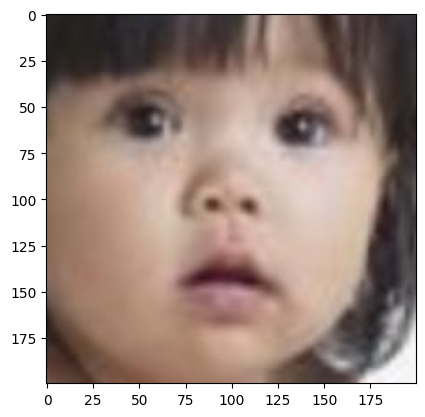

In [ ]:
img = Image.open(df['image'][0])
plt.imshow(img)
plt.show()

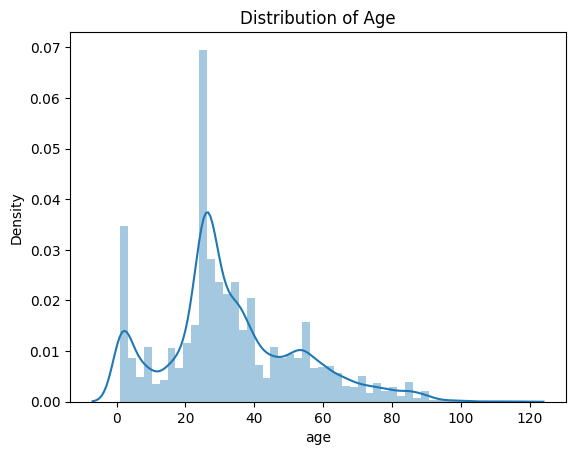

In [ ]:
sns.distplot(df['age']).set(title="Distribution of Age")
plt.show()

In [ ]:
gender_counts = df['gender'].value_counts()
print(f"Male Count: {gender_counts.get(0, 0)}")
print(f"Female Count: {gender_counts.get(1, 0)}")

Male Count: 12391
Female Count: 11317


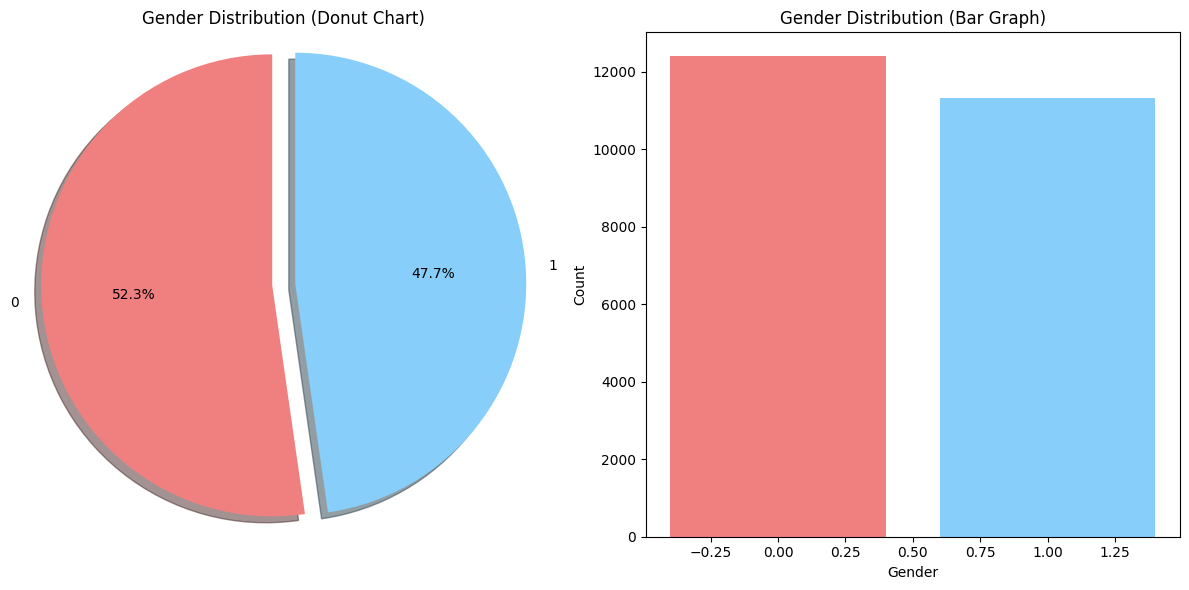

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
labels = gender_counts.index
sizes = gender_counts.values
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Gender Distribution (Donut Chart)')
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

ax2.bar(gender_counts.index, gender_counts.values, color=['lightcoral', 'lightskyblue'])
ax2.set_xlabel('Gender')
ax2.set_ylabel('Count')
ax2.set_title('Gender Distribution (Bar Graph)')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(25, 25))
files = df.iloc[0:25]
for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index + 1)
    img = load_img(file, target_size=(200, 200))
    plt.imshow(img)
    plt.title(f"Age: {age} Gender:{gender_dict[gender]}")
    plt.axis('off')
plt.show()

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
base_dir = '/content/age_gender_data'
os.makedirs(base_dir, exist_ok=True)
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [ ]:
# Since we have continuous age and binary gender, we'll use a custom generator
# However, ImageDataGenerator expects categorical labels, so we'll preprocess accordingly
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
def prepare_data_for_generator(df, target_dir):
    for idx, row in df.iterrows():
        img_path = row['image']
        age = row['age']
        gender = row['gender']
        class_dir = os.path.join(target_dir, f"gender_{gender}")
        os.makedirs(class_dir, exist_ok=True)
        dest_path = os.path.join(class_dir, f"{idx}_{age}_{gender}.jpg")
        img = load_img(img_path, target_size=(48, 48), color_mode='grayscale')
        img.save(dest_path)

In [ ]:
prepare_data_for_generator(train_df, train_dir)
prepare_data_for_generator(test_df, test_dir)

In [ ]:
train_generator = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='binary',  # For gender (binary classification)
    shuffle=True
)

validation_generator = validation_data_gen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='binary',  # For gender
    shuffle=False
)

Found 18966 images belonging to 2 classes.
Found 4742 images belonging to 2 classes.


In [ ]:
# Custom model for age and gender prediction
input_shape = (48, 48, 1)
inputs = Input(shape=input_shape)

conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
dropout1 = Dropout(0.25)(pool1)

conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(dropout1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(128, kernel_size=(3, 3), activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv4)
dropout2 = Dropout(0.25)(pool3)

flatten = Flatten()(dropout2)
dense1 = Dense(1024, activation='relu')(flatten)
dropout3 = Dropout(0.5)(dense1)

# Gender output (binary classification)
gender_output = Dense(1, activation='sigmoid', name='gender_out')(dropout3)
# Age output (regression)
age_output = Dense(1, activation='linear', name='age_out')(dropout3)

# Define model
model = Model(inputs=inputs, outputs=[gender_output, age_output])

In [ ]:
# Compile model
model.compile(
    loss={'gender_out': 'binary_crossentropy', 'age_out': 'mae'},
    optimizer=Adam(learning_rate=0.0001),
    metrics={'gender_out': 'accuracy', 'age_out': 'mae'}
)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 46, 46,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 44, 44,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 22, 22,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 22, 22,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 20, 20,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 10, 10,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 4, 4, 128) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 4, 4, 128) │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  2,098,176 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1024)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │      1,025 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │      1,025 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,340,482 (8.93 MB)

 Trainable params: 2,340,482 (8.93 MB)

 Non-trainable params: 0 (0.00 B)

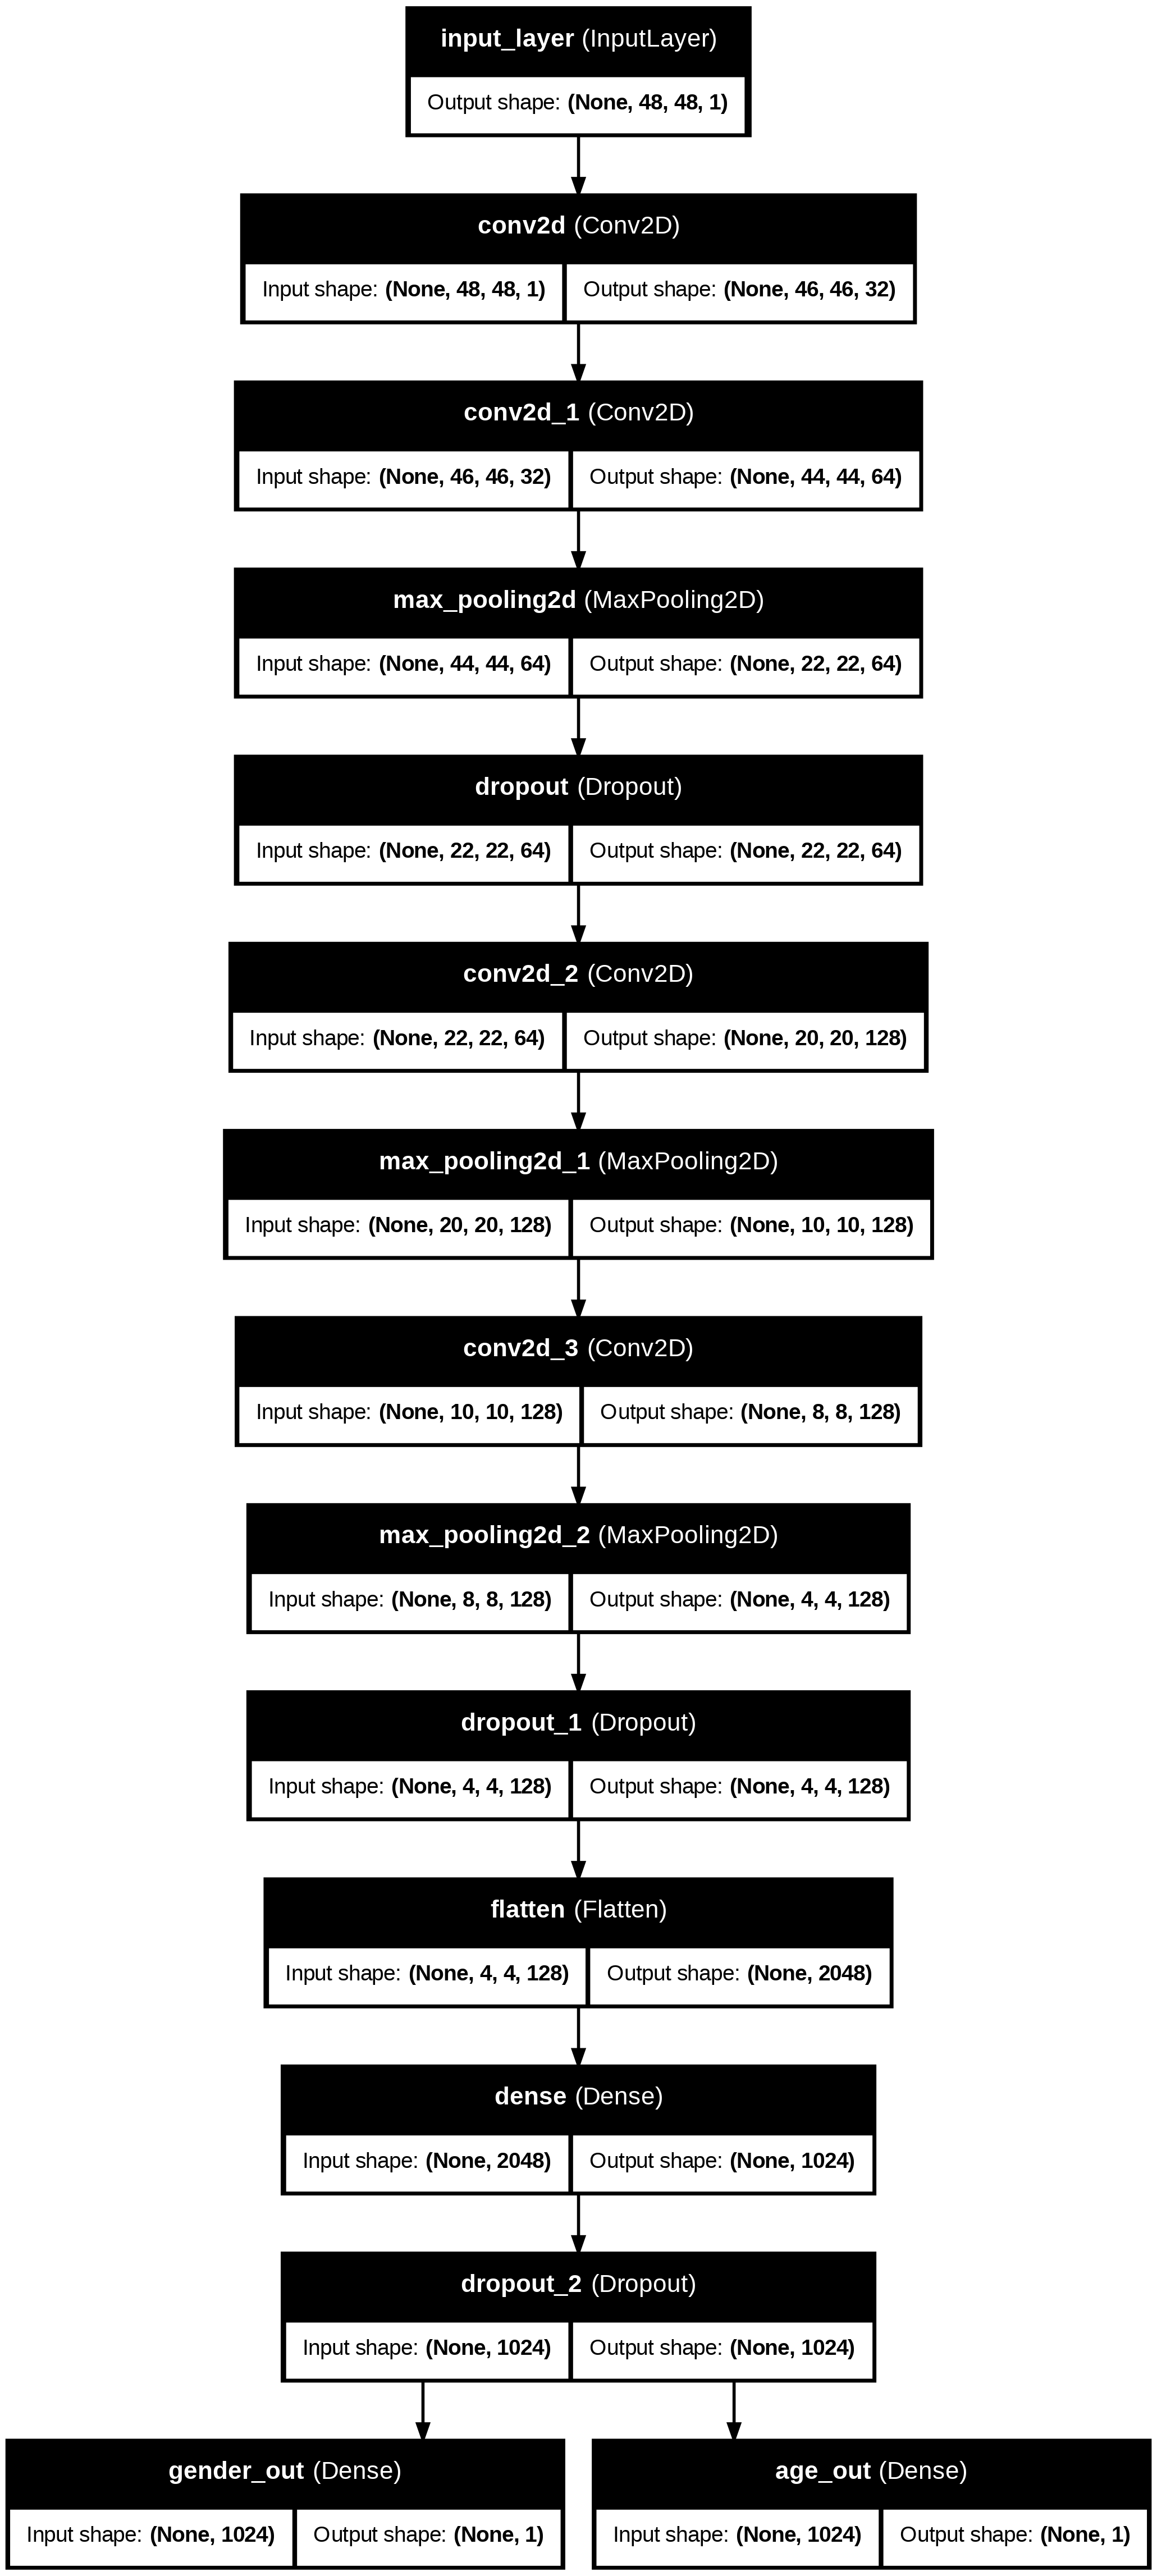

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/Projectss/Age And Gender Prediction/model.png', show_shapes=True, show_layer_names=True)

In [ ]:
def custom_generator(generator, df):
    while True:
        x_batch, y_batch = next(generator)
        indices = generator.index_array[:len(x_batch)]
        age_batch = df.iloc[indices]['age'].values
        yield x_batch, {'gender_out': y_batch, 'age_out': age_batch}

In [ ]:
# Wrap generators
train_custom_gen = custom_generator(train_generator, train_df)
validation_custom_gen = custom_generator(validation_generator, test_df)

In [ ]:
history = model.fit(
    train_custom_gen,
    steps_per_epoch=len(train_df) // 64,
    epochs=100,
    validation_data=validation_custom_gen,
    validation_steps=len(test_df) // 64
)

Epoch 1/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - age_out_loss: 18.3213 - age_out_mae: 18.3213 - gender_out_accuracy: 0.5116 - gender_out_loss: 0.8612 - loss: 19.1825 - val_age_out_loss: 16.2923 - val_age_out_mae: 16.2923 - val_gender_out_accuracy: 0.4981 - val_gender_out_loss: 0.6919 - val_loss: 16.9843
Epoch 2/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - age_out_loss: 15.4104 - age_out_mae: 15.4218 - gender_out_accuracy: 0.5280 - gender_out_loss: 0.8038 - loss: 16.2234 - val_age_out_loss: 17.3577 - val_age_out_mae: 17.3577 - val_gender_out_accuracy: 0.5997 - val_gender_out_loss: 0.6538 - val_loss: 18.0115
Epoch 3/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - age_out_loss: 15.2478 - age_out_mae: 15.2514 - gender_out_accuracy: 0.5769 - gender_out_loss: 0.7181 - loss: 15.9672 - val_age_out_loss: 17.5455 - val_age_out_mae: 17.5455 - val_gender_out_accuracy: 0.6493 - val_gender_out_loss: 0.6217 - val_loss: 18.1672
Epoch 4/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - age_o

In [ ]:
with open('/content/drive/MyDrive/Projectss/Age And Gender Prediction/age_gender_model_history128.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
model_json = model.to_json()
with open("/content/drive/MyDrive/Projectss/Age And Gender Prediction/age_gender_model_history128.pkl", "w") as json_file:
    json_file.write(model_json)
model.save_weights('/content/drive/MyDrive/Projectss/Age And Gender Prediction/age_gender_model.weights.h5')

<Figure size 640x480 with 0 Axes>

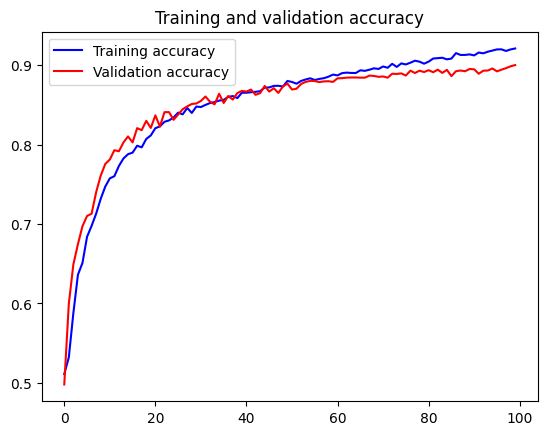

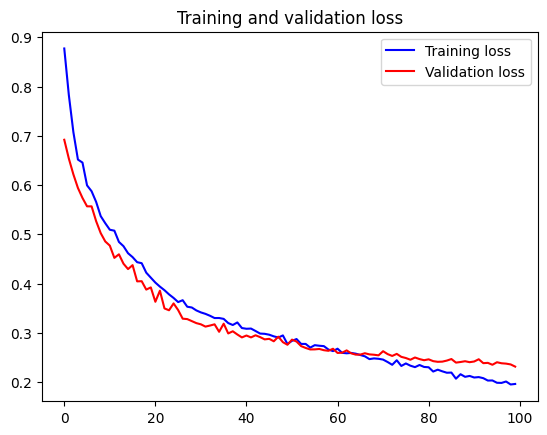

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

<Figure size 640x480 with 0 Axes>

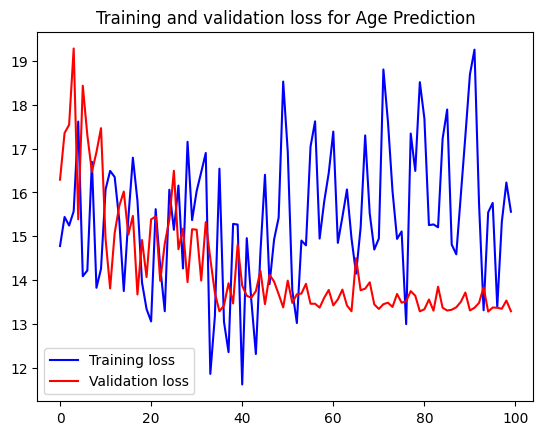

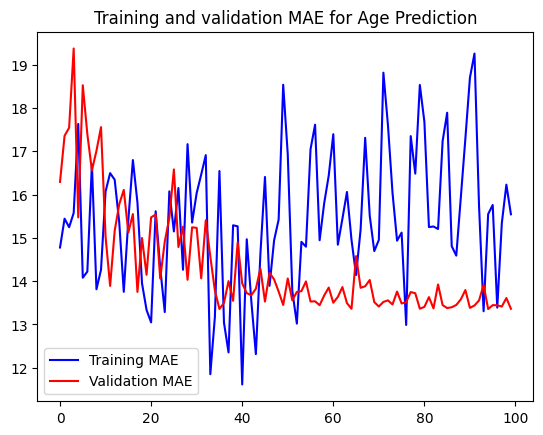

<Figure size 640x480 with 0 Axes>

In [ ]:

import matplotlib.pyplot as plt

# Plotting training and validation loss for age prediction

loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss for Age Prediction')
plt.legend(loc=0)
plt.figure()

# Plotting training and validation MAE for age prediction

mae = history.history['age_out_mae']
val_mae = history.history['val_age_out_mae']
epochs = range(len(acc))

plt.plot(epochs, mae, 'b', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Validation MAE')
plt.title('Training and validation MAE for Age Prediction')
plt.legend(loc=0)
plt.figure()


In [ ]:
def predict_external_image(image_path, model):
    img = load_img(image_path, target_size=(48, 48), color_mode='grayscale')
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, 48, 48, 1)
    pred = model.predict(img_array)
    pred_gender = gender_dict[round(pred[0][0][0])]
    pred_age = round(pred[1][0][0])
    return pred_gender, pred_age

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
Predicted Gender: Male, Predicted Age: 30


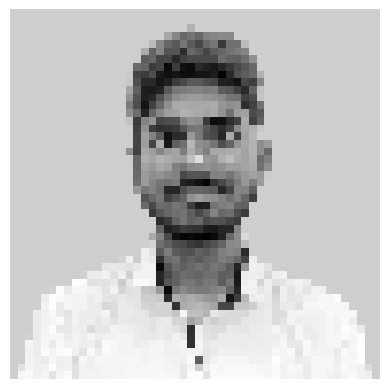

In [ ]:
external_image_path = '/content/drive/MyDrive/Projects/Age_Gender_Prediction/mypic123 (1).png'  # Replace with actual path
pred_gender, pred_age = predict_external_image(external_image_path, model)
print(f"Predicted Gender: {pred_gender}, Predicted Age: {pred_age}")
plt.imshow(load_img(external_image_path, target_size=(48, 48), color_mode='grayscale'), cmap='gray')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Gender: Female, Predicted Age: 29


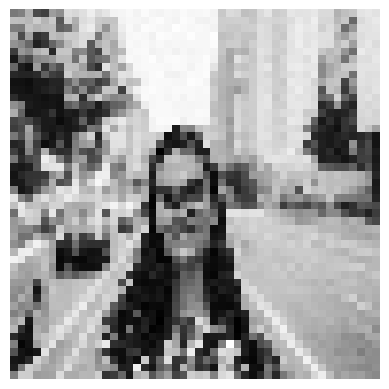

In [ ]:
external_image_path = '/content/drive/MyDrive/Projects/Age_Gender_Prediction/Woman.jpg'  # Replace with actual path
pred_gender, pred_age = predict_external_image(external_image_path, model)
print(f"Predicted Gender: {pred_gender}, Predicted Age: {pred_age}")
plt.imshow(load_img(external_image_path, target_size=(48, 48), color_mode='grayscale'), cmap='gray')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Gender: Male, Predicted Age: 29


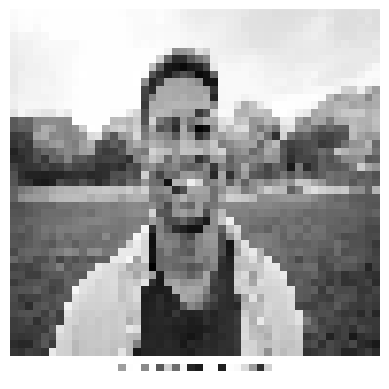

In [ ]:
external_image_path = '/content/drive/MyDrive/Projects/Age_Gender_Prediction/handsome-happy-african-american-bearded-260nw-2460702995.webp'  # Replace with actual path
pred_gender, pred_age = predict_external_image(external_image_path, model)
print(f"Predicted Gender: {pred_gender}, Predicted Age: {pred_age}")
plt.imshow(load_img(external_image_path, target_size=(48, 48), color_mode='grayscale'), cmap='gray')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicted Gender: Female, Predicted Age: 30


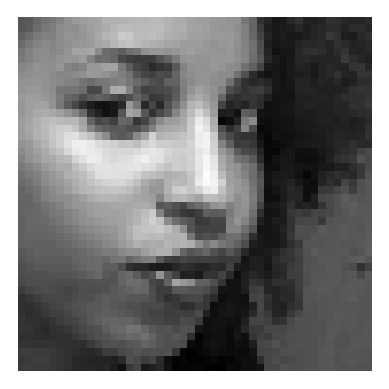

In [ ]:
external_image_path = '/content/drive/MyDrive/Projects/Age_Gender_Prediction/download.png'  # Replace with actual path
pred_gender, pred_age = predict_external_image(external_image_path, model)
print(f"Predicted Gender: {pred_gender}, Predicted Age: {pred_age}")
plt.imshow(load_img(external_image_path, target_size=(48, 48), color_mode='grayscale'), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Updated: Import required libraries for statistical tests
from scipy import stats
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd

# Updated: Function to get test set predictions for continuous age
def get_test_predictions(model, generator, df, batch_size=64):
    """
    Generate predictions for the test set.
    Returns true and predicted labels for gender and continuous ages.
    """
    true_genders = []
    pred_genders = []
    true_ages = []
    pred_ages = []

    steps = len(df) // batch_size
    generator.reset()  # Ensure generator starts from beginning

    for _ in range(steps):
        x_batch, y_batch = next(generator)
        indices = generator.index_array[:len(x_batch)]
        true_gender_batch = y_batch
        true_age_batch = df.iloc[indices]['age'].values
        pred_batch = model.predict(x_batch, verbose=0)
        pred_gender_batch = np.round(pred_batch[0]).astype(int).flatten()
        pred_age_batch = pred_batch[1].flatten()

        true_genders.extend(true_gender_batch)
        pred_genders.extend(pred_gender_batch)
        true_ages.extend(true_age_batch)
        pred_ages.extend(pred_age_batch)

    return (np.array(true_genders), np.array(pred_genders),
            np.array(true_ages), np.array(pred_ages))

# Updated: Perform statistical tests on test set predictions
print("\nStatistical Analysis of Test Set Predictions\n" + "="*40)

# Get test set predictions
true_genders, pred_genders, true_ages, pred_ages = get_test_predictions(
    model, validation_generator, test_df
)

# 1. T-test: Compare age prediction errors by gender
male_indices = true_genders == 0
female_indices = true_genders == 1
male_age_errors = true_ages[male_indices] - pred_ages[male_indices]
female_age_errors = true_ages[female_indices] - pred_ages[female_indices]

t_stat, t_p_value = stats.ttest_ind(male_age_errors, female_age_errors, equal_var=False)
print("\nT-test: Difference in age prediction errors between genders")
print(f"T-statistic: {t_stat:.3f}, P-value: {t_p_value:.3f}")
if t_p_value < 0.05:
    print("Significant difference in age prediction errors between male and female groups.")
else:
    print("No significant difference in age prediction errors between male and female groups.")

# 2. Chi-square: Association between predicted gender and binned predicted ages
# Bin predicted ages into ranges for categorical analysis
age_bins = [0, 20, 40, 60, 120]  # Ranges: 0-20, 21-40, 41-60, 61+
age_labels = ['0-20', '21-40', '41-60', '61+']
pred_age_bins = pd.cut(pred_ages, bins=age_bins, labels=range(len(age_labels)), include_lowest=True)
contingency_table = pd.crosstab(pred_genders, pred_age_bins)
chi2_stat, chi2_p_value, dof, _ = stats.chi2_contingency(contingency_table)
print("\nChi-square: Association between predicted gender and binned predicted ages")
print(f"Chi2 statistic: {chi2_stat:.3f}, P-value: {chi2_p_value:.3f}, Degrees of freedom: {dof}")
if chi2_p_value < 0.05:
    print("Significant association between predicted gender and binned predicted ages.")
else:
    print("No significant association between predicted gender and binned predicted ages.")

# 3. ANOVA: Compare age prediction errors across binned true age ranges
true_age_bins = pd.cut(true_ages, bins=age_bins, labels=range(len(age_labels)), include_lowest=True)
age_errors = true_ages - pred_ages
error_groups = [age_errors[true_age_bins == i] for i in range(len(age_labels)) if np.sum(true_age_bins == i) > 0]

if len(error_groups) >= 2:
    f_stat, f_p_value = stats.f_oneway(*error_groups)
    print("\nANOVA: Differences in age prediction errors across true age ranges")
    print(f"F-statistic: {f_stat:.3f}, P-value: {f_p_value:.3f}")
    if f_p_value < 0.05:
        print("Significant differences in age prediction errors across true age ranges.")
    else:
        print("No significant differences in age prediction errors across true age ranges.")
else:
    print("\nANOVA: Not enough data to perform ANOVA across true age ranges.")

# 4. Z-test (proportion test): Test gender prediction accuracy
gender_accuracy = accuracy_score(true_genders, pred_genders)
n_samples = len(true_genders)
expected_proportion = 0.5  # Null hypothesis: random guessing
z_stat = (gender_accuracy - expected_proportion) / np.sqrt(expected_proportion * (1 - expected_proportion) / n_samples)
z_p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))  # Two-tailed test
print("\nZ-test: Gender prediction accuracy vs. random guessing")
print(f"Z-statistic: {z_stat:.3f}, P-value: {z_p_value:.3f}")
if z_p_value < 0.05:
    print("Gender prediction accuracy significantly better than random guessing.")
else:
    print("Gender prediction accuracy not significantly better than random guessing.")

# Updated: Relate external image prediction to test set results
# Find test set samples with true ages close to the predicted age (±5 years)
age_tolerance = 5
similar_age_indices = (true_ages >= pred_age - age_tolerance) & (true_ages <= pred_age + age_tolerance)
external_gender_class = 0 if pred_gender == 'Male' else 1

# Calculate accuracy for gender and MAE for similar ages in test set
gender_acc = accuracy_score(
    true_genders[true_genders == external_gender_class],
    pred_genders[true_genders == external_gender_class]
) if np.sum(true_genders == external_gender_class) > 0 else np.nan
age_mae = np.mean(np.abs(true_ages[similar_age_indices] - pred_ages[similar_age_indices])) if np.sum(similar_age_indices) > 0 else np.nan

print(f"\nExternal Image Prediction Context")
print(f"Predicted Gender: {pred_gender}, Test Set Accuracy for this Gender: {gender_acc:.3f}")
print(f"Predicted Age: {pred_age}, Test Set MAE for Similar Ages (±{age_tolerance} years): {age_mae:.3f}")


Statistical Analysis of Test Set Predictions

T-test: Difference in age prediction errors between genders
T-statistic: -0.467, P-value: 0.640
No significant difference in age prediction errors between male and female groups.

Chi-square: Association between predicted gender and binned predicted ages
Chi2 statistic: 0.000, P-value: 1.000, Degrees of freedom: 0
No significant association between predicted gender and binned predicted ages.

ANOVA: Differences in age prediction errors across true age ranges
F-statistic: 16423.793, P-value: 0.000
Significant differences in age prediction errors across true age ranges.

Z-test: Gender prediction accuracy vs. random guessing
Z-statistic: 54.724, P-value: 0.000
Gender prediction accuracy significantly better than random guessing.

External Image Prediction Context
Predicted Gender: Female, Test Set Accuracy for this Gender: 0.877
Predicted Age: 30, Test Set MAE for Similar Ages (±5 years): 3.450
